# Data Analytics Project - Models

# Pair 1 - BAJAJ-AUTO LSTM

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


---

# 2. Get Pair 1 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair1/Pair1_orders.csv')
orders_df.head()

,Date,HEROMOTOCO_Close,BAJAJ-AUTO_Close,Spread,zscore,Orders
0,2018-09-04,3184.149902,2735.550049,448.599854,2.186180,SHORT
1,2018-09-05,3145.399902,2772.300049,373.099854,1.220189,FLAT
2,2018-09-06,3164.850098,2783.100098,381.750000,1.330864,FLAT
3,2018-09-07,3329.350098,2923.550049,405.800049,1.638574,SHORT
4,2018-09-10,3278.300049,2868.600098,409.699951,1.688472,SHORT


In [3]:
orders_df.tail()

,Date,HEROMOTOCO_Close,BAJAJ-AUTO_Close,Spread,zscore,Orders
54,2018-11-27,2958.149902,2599.649902,358.500000,1.033390,FLAT
55,2018-11-28,2999.149902,2603.899902,395.250000,1.503591,SHORT
56,2018-11-29,3016.800049,2724.000000,292.800049,0.192787,FLAT
57,2018-11-30,3055.199951,2745.699951,309.500000,0.406456,FLAT
58,2018-12-03,3039.899902,2736.000000,303.899902,0.334805,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

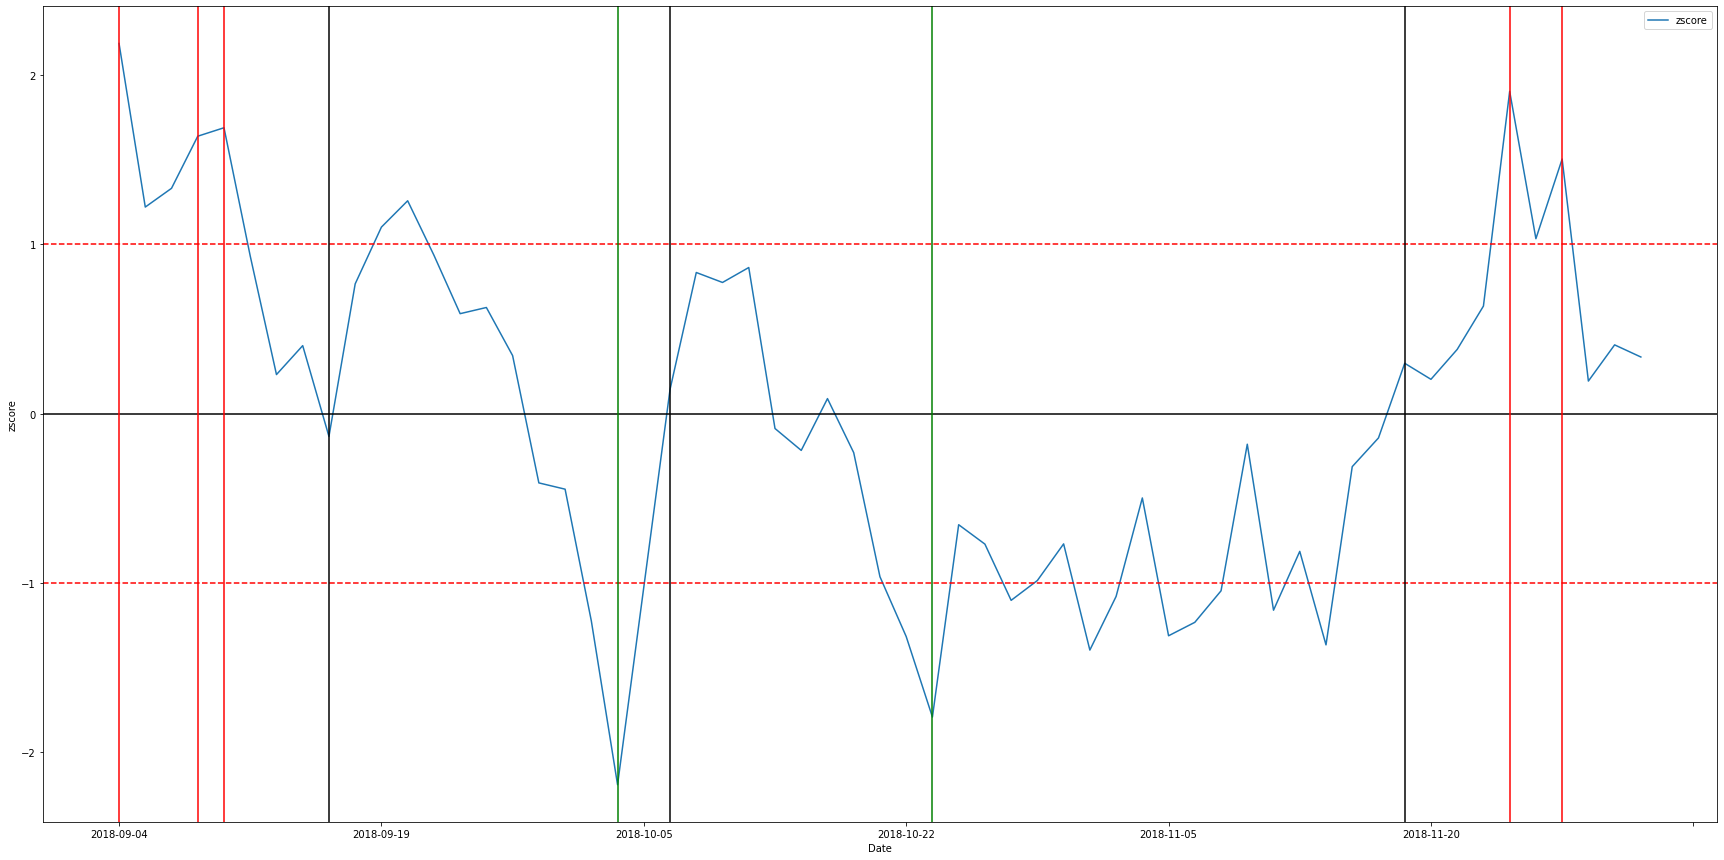

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

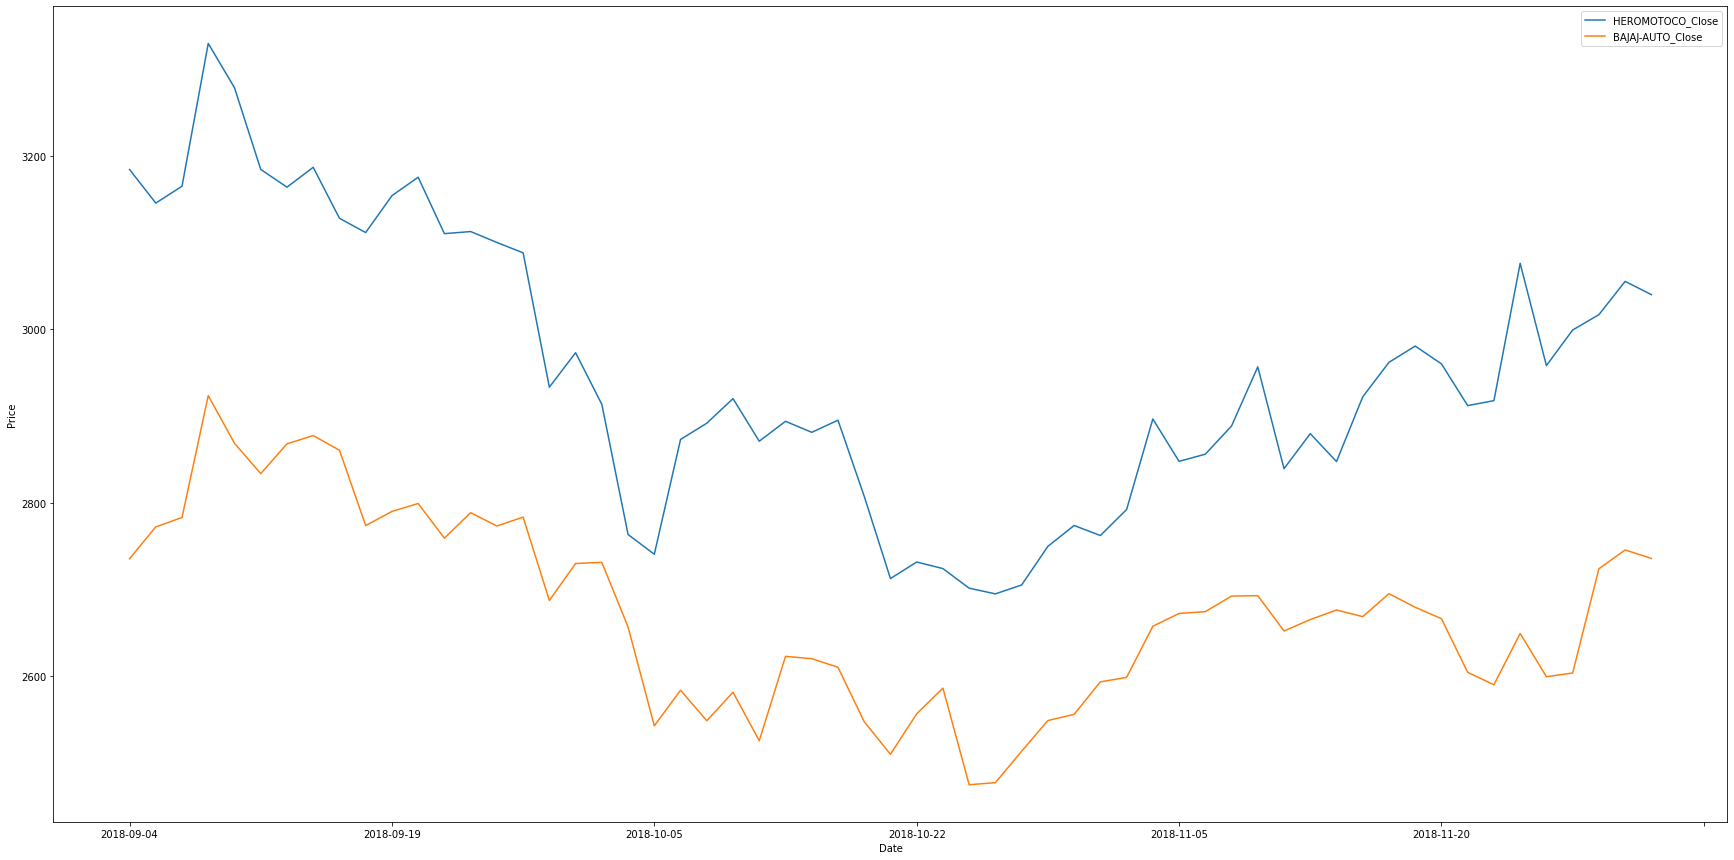

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['HEROMOTOCO_Close', 'BAJAJ-AUTO_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. BAJAJ-AUTO Linear Regression Model

## 3.1. Get the Complete BAJAJ-AUTO dataset

In [6]:
bajaj_df = pd.read_csv("../../Storage/Companies_with_names_exchange/BAJAJ-AUTONSE.csv")
bajaj_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,2654.300049,2552.000000,2642.699951,2598.500000,323342.0,2336.084473,BAJAJ-AUTO,NSE
1,2017-01-03,2632.199951,2561.449951,2594.000000,2619.199951,420196.0,2354.694336,BAJAJ-AUTO,NSE
2,2017-01-04,2698.550049,2615.949951,2625.199951,2684.100098,343922.0,2413.040283,BAJAJ-AUTO,NSE
3,2017-01-05,2730.000000,2685.000000,2694.000000,2723.350098,188686.0,2448.326416,BAJAJ-AUTO,NSE
4,2017-01-06,2739.899902,2696.699951,2721.000000,2707.350098,159484.0,2433.942383,BAJAJ-AUTO,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get BAJAJ-AUTO training data

### 3.2.1 Get complete bajaj dataset

In [7]:
bajaj_df = bajaj_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
bajaj_df.head()

,Date,Close
0,2017-01-02,2598.500000
1,2017-01-03,2619.199951
2,2017-01-04,2684.100098
3,2017-01-05,2723.350098
4,2017-01-06,2707.350098


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
bajaj_df_train = bajaj_df[bajaj_df['Date'] >= '2017-09-03']
bajaj_df_train.head()

,Date,Close
166,2017-09-04,2915.149902
167,2017-09-05,2950.699951
168,2017-09-06,2920.550049
169,2017-09-07,2965.449951
170,2017-09-08,2915.449951


In [9]:
bajaj_df_train = bajaj_df_train[bajaj_df_train['Date'] <= '2018-09-04']
bajaj_df_train.tail()

,Date,Close
412,2018-08-29,2689.100098
413,2018-08-30,2701.649902
414,2018-08-31,2744.850098
415,2018-09-03,2771.899902
416,2018-09-04,2735.550049


### 3.2.3 Get the training data

In [10]:
bajaj_train = bajaj_df_train.copy()

In [11]:
bajaj_train = bajaj_train.reset_index(drop=True)
bajaj_train = bajaj_train.copy()
bajaj_train.head()

,Date,Close
0,2017-09-04,2915.149902
1,2017-09-05,2950.699951
2,2017-09-06,2920.550049
3,2017-09-07,2965.449951
4,2017-09-08,2915.449951


In [12]:
bajaj_train_plot_copy = bajaj_train.copy()
bajaj_train.tail()

,Date,Close
246,2018-08-29,2689.100098
247,2018-08-30,2701.649902
248,2018-08-31,2744.850098
249,2018-09-03,2771.899902
250,2018-09-04,2735.550049


In [13]:
bajaj_train = bajaj_train.drop(columns=['Date'])
bajaj_train = bajaj_train.values
bajaj_train

array([[2915.14990234],
       [2950.69995117],
       [2920.55004883],
       [2965.44995117],
       [2915.44995117],
       [2929.60009766],
       [2935.75      ],
       [2934.94995117],
       [2928.35009766],
       [3025.60009766],
       [3137.39990234],
       [3115.44995117],
       [3090.55004883],
       [3078.85009766],
       [3042.44995117],
       [3044.10009766],
       [3044.89990234],
       [3031.25      ],
       [3039.44995117],
       [3109.39990234],
       [3162.19995117],
       [3173.5       ],
       [3130.80004883],
       [3141.55004883],
       [3125.44995117],
       [3134.69995117],
       [3143.89990234],
       [3155.89990234],
       [3160.85009766],
       [3224.80004883],
       [3259.94995117],
       [3226.80004883],
       [3217.94995117],
       [3217.64990234],
       [3210.05004883],
       [3232.25      ],
       [3283.39990234],
       [3300.14990234],
       [3282.19995117],
       [3257.10009766],
       [3239.75      ],
       [3241.100

In [14]:
len(bajaj_train)

251

## 3.3. Get BAJAJ-AUTO Test Data

In [15]:
bajaj_test = bajaj_df[(bajaj_df['Date'] >= '2018-09-04') & (bajaj_df['Date'] <= '2018-12-03')].copy()
bajaj_test.head()

,Date,Close
416,2018-09-04,2735.550049
417,2018-09-05,2772.300049
418,2018-09-06,2783.100098
419,2018-09-07,2923.550049
420,2018-09-10,2868.600098


In [16]:
bajaj_test.tail()

,Date,Close
470,2018-11-27,2599.649902
471,2018-11-28,2603.899902
472,2018-11-29,2724.000000
473,2018-11-30,2745.699951
474,2018-12-03,2736.000000


In [17]:
bajaj_test.reset_index(drop=True, inplace=True)
bajaj_test.index += 251
bajaj_test.head()

,Date,Close
251,2018-09-04,2735.550049
252,2018-09-05,2772.300049
253,2018-09-06,2783.100098
254,2018-09-07,2923.550049
255,2018-09-10,2868.600098


In [18]:
bajaj_test_plot_copy = bajaj_test.copy()
bajaj_test = bajaj_test.drop(columns=['Date'])
bajaj_test = bajaj_test.values
bajaj_test

array([[2735.55004883],
       [2772.30004883],
       [2783.10009766],
       [2923.55004883],
       [2868.60009766],
       [2833.69995117],
       [2867.94995117],
       [2877.5       ],
       [2860.64990234],
       [2773.80004883],
       [2790.10009766],
       [2799.19995117],
       [2759.30004883],
       [2788.69995117],
       [2773.30004883],
       [2783.55004883],
       [2687.44995117],
       [2730.10009766],
       [2731.39990234],
       [2657.        ],
       [2543.05004883],
       [2584.10009766],
       [2548.85009766],
       [2581.80004883],
       [2525.80004883],
       [2623.05004883],
       [2620.44995117],
       [2610.5       ],
       [2547.80004883],
       [2510.25      ],
       [2556.89990234],
       [2586.5       ],
       [2475.14990234],
       [2477.55004883],
       [2513.75      ],
       [2549.10009766],
       [2556.25      ],
       [2593.69995117],
       [2598.85009766],
       [2657.75      ],
       [2672.55004883],
       [2674.600

In [19]:
len(bajaj_test)

59

## 3.4 Create and Train BAJAJ-AUTO Model

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(bajaj_train)
scaled_train_data

array([[0.37340288],
       [0.41815089],
       [0.38020022],
       [0.43671719],
       [0.37378056],
       [0.39159181],
       [0.3993329 ],
       [0.39832585],
       [0.3900184 ],
       [0.51243014],
       [0.65315619],
       [0.62552707],
       [0.59418475],
       [0.57945764],
       [0.5336396 ],
       [0.53571669],
       [0.53672343],
       [0.51954185],
       [0.5298634 ],
       [0.61791168],
       [0.68437282],
       [0.69859656],
       [0.64484874],
       [0.65838011],
       [0.6381144 ],
       [0.64975767],
       [0.66133795],
       [0.67644274],
       [0.68267371],
       [0.7631696 ],
       [0.80741392],
       [0.76568706],
       [0.75454716],
       [0.75416947],
       [0.74460329],
       [0.77254709],
       [0.83693114],
       [0.85801491],
       [0.83542072],
       [0.80382672],
       [0.78198759],
       [0.783687  ],
       [0.75391779],
       [0.74435161],
       [0.68368045],
       [0.71816991],
       [0.73195297],
       [0.799

In [21]:
X_train, y_train = [], []
for i in range(10,len(bajaj_train)):
    X_train.append(scaled_train_data[i-10:i,0])
    y_train.append(scaled_train_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [22]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [23]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 2s - loss: 0.0189


## 3.5. Get predictions

In [24]:
scaled_test_data = bajaj_test.reshape(-1,1)
scaled_test_data = scaler.transform(scaled_test_data)
scaled_test_data.shape

(59, 1)

In [25]:
X_test = []
for i in range(10, scaled_test_data.shape[0]):
    X_test.append(scaled_test_data[i-10:i,0])
X_test = np.array(X_test)
X_test

array([[ 0.1473347 ,  0.19359313,  0.2071875 ,  0.38397642,  0.31480913,
         0.27087918,  0.31399077,  0.32601173,  0.30480196,  0.19548122],
       [ 0.19359313,  0.2071875 ,  0.38397642,  0.31480913,  0.27087918,
         0.31399077,  0.32601173,  0.30480196,  0.19548122,  0.21599863],
       [ 0.2071875 ,  0.38397642,  0.31480913,  0.27087918,  0.31399077,
         0.32601173,  0.30480196,  0.19548122,  0.21599863,  0.22745291],
       [ 0.38397642,  0.31480913,  0.27087918,  0.31399077,  0.32601173,
         0.30480196,  0.19548122,  0.21599863,  0.22745291,  0.1772296 ],
       [ 0.31480913,  0.27087918,  0.31399077,  0.32601173,  0.30480196,
         0.19548122,  0.21599863,  0.22745291,  0.1772296 ,  0.21423622],
       [ 0.27087918,  0.31399077,  0.32601173,  0.30480196,  0.19548122,
         0.21599863,  0.22745291,  0.1772296 ,  0.21423622,  0.19485186],
       [ 0.31399077,  0.32601173,  0.30480196,  0.19548122,  0.21599863,
         0.22745291,  0.1772296 ,  0.21423622

In [26]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
len(closing_price)

49

In [27]:
print('Mean Absolute Error:', metrics.mean_absolute_error(bajaj_test[10:], closing_price))
print('Mean Squared Error:', metrics.mean_squared_error(bajaj_test[10:], closing_price))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(bajaj_test[10:], closing_price)))

Mean Absolute Error: 72.42936363998724
Mean Squared Error: 7554.010239179037
Root Mean Squared Error: 86.91380925479585


## 3.6. Visualize the predicitons vs test data

In [28]:
closing_price_df = pd.DataFrame(closing_price, columns=['price'])
closing_price_df.index += 260
closing_price = closing_price_df['price']
closing_price

260    2865.964355
261    2863.805664
262    2859.333984
263    2850.984863
264    2838.676025
265    2829.504395
266    2823.580322
267    2809.201660
268    2795.912354
269    2785.045410
270    2772.994385
271    2749.203613
272    2724.722168
273    2700.636963
274    2679.019287
275    2657.286133
276    2643.700195
277    2639.193604
278    2634.981201
279    2627.405518
280    2618.570801
281    2615.643066
282    2613.975098
283    2607.228027
284    2596.214355
285    2589.324463
286    2582.722168
287    2579.823486
288    2582.159424
289    2589.702148
290    2603.803955
291    2618.970703
292    2633.809570
293    2653.833496
294    2672.400391
295    2684.261719
296    2692.297852
297    2699.247314
298    2703.252441
299    2708.326172
300    2710.154541
301    2709.985596
302    2704.095215
303    2693.893311
304    2687.299561
305    2680.747559
306    2673.516846
307    2675.824463
308    2685.408691
Name: price, dtype: float32

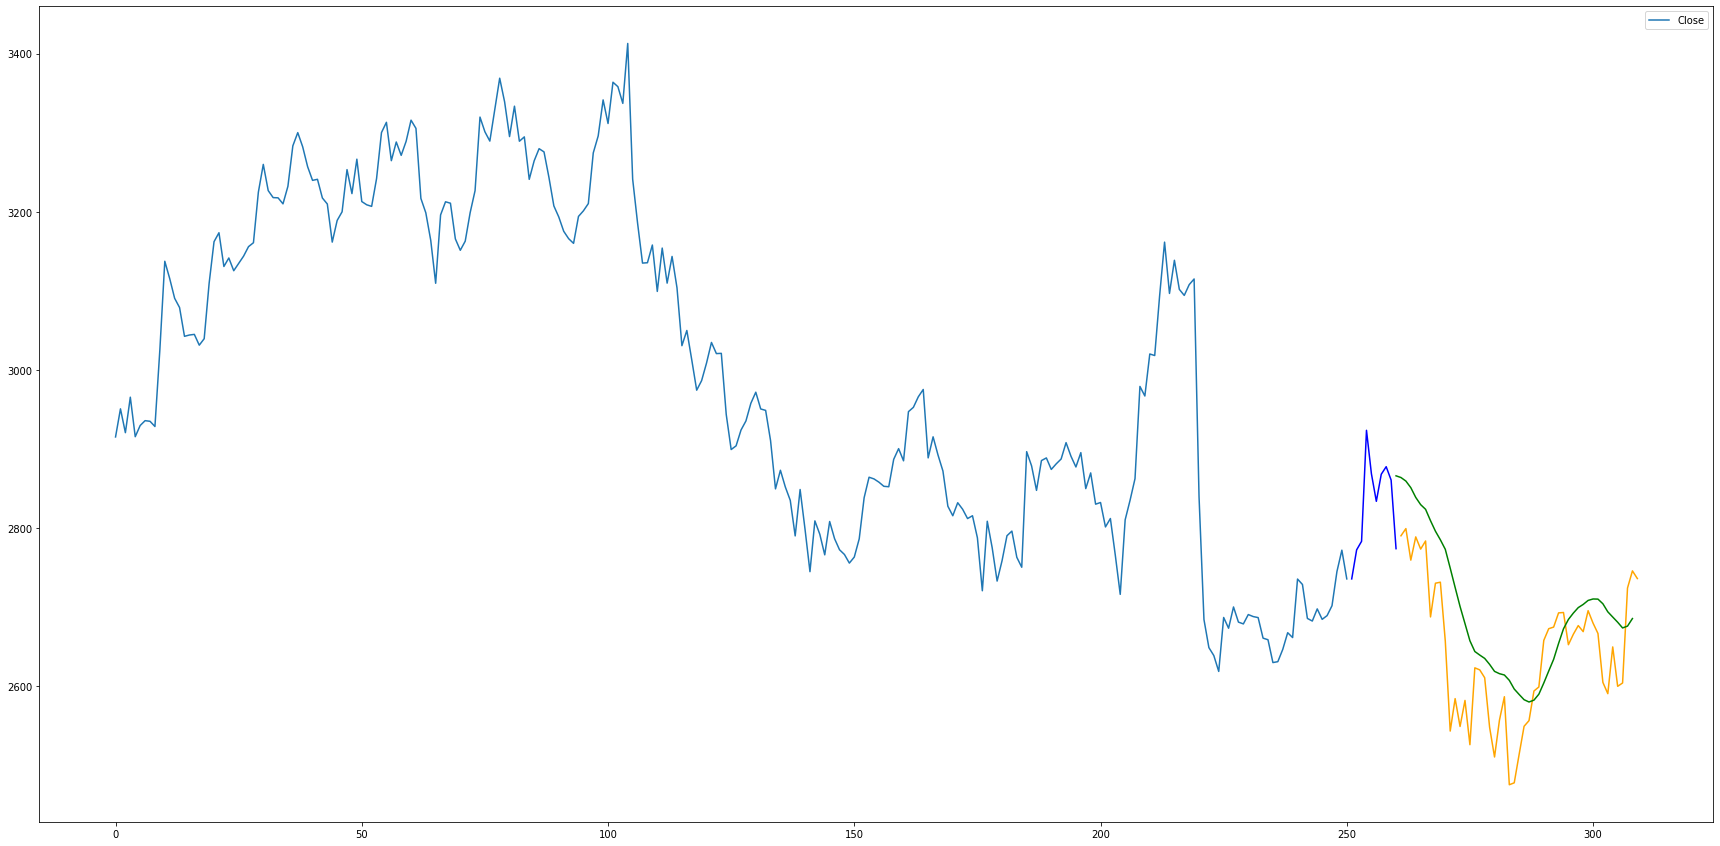

In [29]:
bajaj_model_plt = bajaj_train_plot_copy.plot(y=['Close'], figsize=(30,15))
bajaj_model_plt.plot(bajaj_test_plot_copy["Close"][:10], c='blue')
bajaj_model_plt.plot(bajaj_test_plot_copy["Close"][10:], c='orange')
bajaj_model_plt.plot(closing_price, c='green')

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results in a file

In [30]:
bajaj_predictions_df = pd.read_csv('Bajaj_predicitions.csv')
bajaj_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close
0,2018-09-04,2735.550049,2828.063046,2758.982897
1,2018-09-05,2772.300049,2827.527597,2758.487833
2,2018-09-06,2783.100098,2826.992147,2753.048689
3,2018-09-07,2923.550049,2826.456697,2750.827712
4,2018-09-10,2868.600098,2824.743246,2751.573240


In [31]:
bajaj_predictions_df.tail()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close
54,2018-11-27,2599.649902,2763.052865,2437.389158
55,2018-11-28,2603.899902,2762.517415,2433.639972
56,2018-11-29,2724.000000,2761.981965,2427.758682
57,2018-11-30,2745.699951,2785.681728,2446.218155
58,2018-12-03,2736.000000,2706.047347,2475.259363


In [32]:
closing_price_df.index -= 250
closing_price_df

,price
10,2865.964355
11,2863.805664
12,2859.333984
13,2850.984863
14,2838.676025
15,2829.504395
16,2823.580322
17,2809.201660
18,2795.912354
19,2785.045410


In [33]:
bajaj_predictions_df['LSTM_Close'] = closing_price_df['price']
bajaj_predictions_df

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close,LSTM_Close
0,2018-09-04,2735.550049,2828.063046,2758.982897,NaN
1,2018-09-05,2772.300049,2827.527597,2758.487833,NaN
2,2018-09-06,2783.100098,2826.992147,2753.048689,NaN
3,2018-09-07,2923.550049,2826.456697,2750.827712,NaN
4,2018-09-10,2868.600098,2824.743246,2751.573240,NaN
5,2018-09-11,2833.699951,2824.207796,2656.435953,NaN
6,2018-09-12,2867.949951,2823.672347,2587.443083,NaN
7,2018-09-14,2877.500000,2822.601447,2575.225774,NaN
8,2018-09-17,2860.649902,2820.887996,2564.203929,NaN
9,2018-09-18,2773.800049,2820.352546,2569.011648,NaN


In [34]:
bajaj_predictions_df.to_csv('Bajaj_predicitions.csv', index=False)